# How to Develop a 1D Generative Adversarial Network From Scratch in Keras

Original post from [Machine Learning Mastery](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-1-dimensional-function-from-scratch-in-keras/)

## What is a Generative Model

A __generator model__ is capable of generating _new artificial_ samples that plausibly could have come from an existing __distribution__ of samples.

GANs are comprised of both __generator__ and __discriminator__ models.
- The generator is responsible for __generating__ new samples from the domain, and the discriminator is responsible for __classifying__ whether samples are __real__ or __fake__ (generated).
- Importantly, the performance of the discriminator model is used to update _both_ the model weights of the discriminator itself and the generator model.
  - This means that the generator never actually sees examples from the domain and is adapted based on how well the discriminator performs.

## 1-Dimensional Generative Model

A simple task that provides a good context for developing a simple GAN from scratch is a one-dimensional function. This is because both real and generated samples can be plotted and visually inspected to get an idea of what has been learned. A simple function also does not require sophisticated neural network models, meaning the specific generator and discriminator models used on the architecture can be easily understood.

## Select an One-dimensional Function

The first step is to select a one-dimensional function to model.

Something like the _sigmoid_ function:

$$ y = \frac{1}{1 + e^{-x}} $$


In [ ]:
import numpy as np


# simple function
def my_sigmoid(x):
	return 1/(1+np.exp(-x))


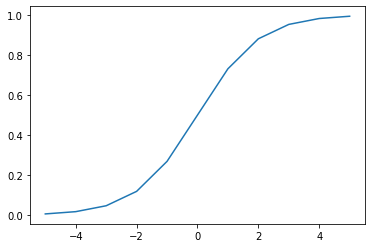

In [ ]:
import matplotlib.pyplot as plt

# define inputs
inputs = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
# calculate outputs
outputs = [my_sigmoid(x) for x in inputs]
# plot the result
plt.plot(inputs, outputs)
plt.show()

We can generate random samples (or points) from the function.

This can be achieved by generating random values between -5 and 5 and calculating the associated output value. Repeating this many times will give a sample of points from the function, e.g. __real samples__.

Plotting these samples using a scatter plot will show the same plot, although comprised of the individual random samples.

In [ ]:
# generate randoms sample from the sigmoid function
def generate_samples(n=100):
	# generate random inputs in [-5, 5]
	x = np.random.uniform(-5, 5, n)
	# generate outputs X^2 (quadratic)
	y = 1/(1+np.exp(-x))
	# stack arrays
	x = x.reshape(n, 1)
	y = y.reshape(n, 1)
	return np.hstack((x, y))

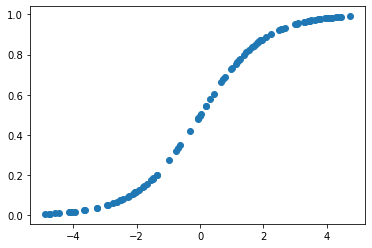

In [ ]:
# generate samples
data = generate_samples()
# plot samples
plt.scatter(data[:, 0], data[:, 1])
plt.show();

We can use this function (`generate_samples()`) as a starting point for generating **real** samples for our discriminator function. Specifically, a sample is comprised of a vector with two elements, one for the *input* and one for the *output* of our one-dimensional function.

We can also imagine how a generator model could generate new samples that we can plot and compare to the expected shape of the __sigmoid__ function. Specifically, a generator would output a vector with two elements: one for the input and one for the output of our __sigmoid__ function.

## Define a Discriminator Model
The next step is to define the discriminator model.

The model must take a sample from our problem, such as a vector with two elements, and output a classification prediction as to whether the sample is *real* or *fake*.

This is a *binary classification* problem.

- **Inputs**: Sample with two real values.
- **Outputs**: Binary classification, likelihood the sample is *real* (or *fake*).

The problem is very simple, meaning that we don’t need a complex neural network to model it.

The discriminator model will have *one* hidden layer with `25` nodes and we will use the `LeakyReLU` activation function and an appropriate weight initialization method called `He` weight initialization.

The output layer will have *one* node for the binary classification using the `sigmoid` activation function.

The model will minimize the *binary cross entropy* loss function, and the **Adam** version of stochastic gradient descent will be used because it is very effective.

The `define_discriminator()` function below defines and returns the discriminator model. The function parameterizes the number of inputs to expect, which defaults to two.

In [ ]:

# define the discriminator model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras.utils import plot_model


In [ ]:
# define the standalone discriminator model
def define_discriminator(n_inputs=2):
  model = Sequential()
  model.add(Dense(25, kernel_initializer='he_uniform', input_dim=n_inputs))
  model.add(LeakyReLU(0.1))
  model.add(Dense(1, activation='sigmoid'))
  # compile model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25)                75        
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 25)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


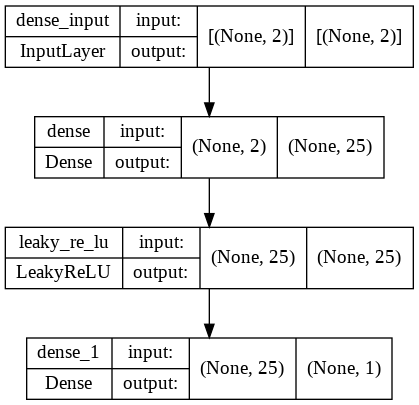

In [ ]:
# define the discriminator model
model = define_discriminator()
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

We could start training this model now with real examples with a class label of `1` and randomly generated samples with a class label of `0`.

There is no need to do this, but the elements we will develop will be useful later, and it helps to see that the discriminator is just a normal neural network model.

First, we can update our `generate_samples()` function from the prediction section and call it `generate_real_samples()` and have it also return the output class labels for the real samples, specifically, an array of `1` values, where `class=1` means real.

In [ ]:
# generate n real samples with class labels
def generate_real_samples(n):
	# generate random inputs in [-5, 5]
	x1 = np.random.uniform(-5, 5, n)
	# generate outputs X^2 (quadratic)
	x2 = 1/(1+np.exp(-x1))
	# stack arrays
	x1 = x1.reshape(n, 1)
	x2 = x2.reshape(n, 1)
	X = np.hstack((x1, x2))
	# generate class labels
	y = np.ones((n, 1))
	return X, y

Next, we can create a copy of this function for creating fake examples.

In this case, we will generate random values in the range -10 and 10 for both elements of a sample. The output class label for all of these examples is 0.

This function (`generate_fake_samples()`) will generate fake data for our model.

In [ ]:
def generate_fake_samples(n):
	# generate random inputs in [-5, 5]
	x1 = np.random.uniform(-10, 10, n)
	# generate outputs X^2 (quadratic)
	x2 = np.random.uniform(-5, 5, n)
	# stack arrays
	x1 = x1.reshape(n, 1)
	x2 = x2.reshape(n, 1)
	X = np.hstack((x1, x2))
	# generate class labels
	y = np.zeros((n, 1))
	return X, y

Next, we need a function to train and evaluate the discriminator model.

This can be achieved by manually enumerating the training epochs and for each epoch generating a *half* batch of *real* examples and a *half* batch of *fake* examples, and updating the model on each, e.g. one whole batch of examples. The `train_discriminator()` function could be used, but in this case, we will use the `train_on_batch()` function provided by keras directly.

The model can then be evaluated on the generated examples and we can report the classification accuracy on both the *real* and *fake* samples.

The `train_discriminator()` function below implements this, training the model for `1,000` batches and using `128` samples per batch (`64` fake and `64` real).

In [ ]:
def train_discriminator(model, n_epochs=1000, n_batch=128):
  half_batch = int(n_batch / 2)
  ids, real_accs, fake_accs = list(), list(), list()
	# run epochs manually
  for i in range(n_epochs):
		# generate real examples
    X_real, y_real = generate_real_samples(half_batch)
		# update model
    model.train_on_batch(X_real, y_real)
		# generate fake examples
    X_fake, y_fake = generate_fake_samples(half_batch)
		# update model
    model.train_on_batch(X_fake, y_fake)
		# evaluate the model
    _, acc_real = model.evaluate(X_real, y_real, verbose=0)
    _, acc_fake = model.evaluate(X_fake, y_fake, verbose=0)
    ids.append(i)
    real_accs.append(acc_real)
    fake_accs.append(acc_fake)

    #print(i, acc_real, acc_fake)
  ids = np.array(ids).reshape(i+1,1)
  real_accs = np.array(real_accs).reshape(i+1,1)
  fake_accs = np.array(fake_accs).reshape(i+1,1)
  return np.hstack((ids, real_accs, fake_accs))

In [ ]:
# define the discriminator model
model = define_discriminator()
# fit the model
hist = train_discriminator(model)

Let's examine the performance of the last `10` epochs.

In [ ]:
print(hist[-10:])

[[9.90000e+02 1.00000e+00 8.43750e-01]
 [9.91000e+02 1.00000e+00 9.21875e-01]
 [9.92000e+02 1.00000e+00 8.90625e-01]
 [9.93000e+02 1.00000e+00 8.59375e-01]
 [9.94000e+02 1.00000e+00 9.06250e-01]
 [9.95000e+02 1.00000e+00 9.68750e-01]
 [9.96000e+02 1.00000e+00 9.37500e-01]
 [9.97000e+02 1.00000e+00 9.53125e-01]
 [9.98000e+02 1.00000e+00 8.28125e-01]
 [9.99000e+02 1.00000e+00 9.06250e-01]]


Running the example generates real and fake examples and updates the model, then evaluates the model on the same examples and prints the classification accuracy.

Your specific results may vary but the model rapidly learns to correctly identify the real examples with perfect accuracy and is very good at identifying the fake examples with `80%` to 90% accuracy.

Training the discriminator model is straightforward. The goal is to train a generator model, not a discriminator model, and that is where the complexity of GANs truly lies.

## Define a Generator Model
The next step is to define the generator model.

The generator model takes as input a point from the latent space and generates a new sample, e.g. a vector with both the input and output elements of our function, e.g. `x` and `sigmoid(x)`.

A latent variable is a hidden or unobserved variable, and a latent space is a multi-dimensional vector space of these variables. We can define the size of the latent space for our problem and the shape or distribution of variables in the latent space.

This is because the latent space has no meaning until the generator model starts assigning meaning to points in the space as it learns. After training, points in the latent space will correspond to points in the output space, e.g. in the space of generated samples.

We will define a small latent space of `5` dimensions and use the standard approach in the GAN literature of using a *Gaussian distribution* for each variable in the latent space. We will generate new inputs by drawing `random numbers` from a standard Gaussian distribution, i.e. mean of zero and a standard deviation of one.

- **Inputs**: Point in latent space, e.g. a five-element vector of Gaussian random numbers.
- **Outputs**: Two-element vector representing a generated sample for our function (`x` and `sigmoid(x)`).

The generator model will be small like the discriminator model.

It will have a single hidden layer with `15` nodes and will use the `LeakyReLU` activation function and the `He` weight initialization. The output layer will have `2` nodes for the 2 elements in a generated vector and will use a `linear` activation function.

A linear activation function is used because we know we want the generator to output a vector of real values and the scale will be `[-5, 5]` for the first element and about `[0.0, 1.0]` for the second element.

The model is not compiled. The reason for this is that the generator model is not fit directly.

The define_generator() function below defines and returns the generator model.

The size of the latent dimension is parameterized in case we want to play with it later, and the output shape of the model is also parameterized, matching the function for defining the discriminator model.

In [ ]:
# define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
  model = Sequential()
  model.add(Dense(15, kernel_initializer='he_uniform', input_dim=latent_dim))
  model.add(LeakyReLU(0.1))
  model.add(Dense(n_outputs, activation='linear'))
  return model



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 15)                90        
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 15)                0         
                                                                 
 dense_5 (Dense)             (None, 2)                 32        
                                                                 
Total params: 122
Trainable params: 122
Non-trainable params: 0
_________________________________________________________________


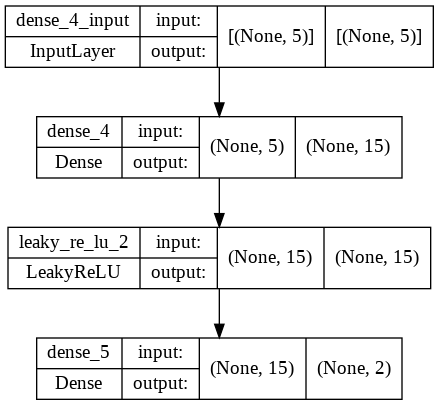

In [ ]:
# define the discriminator model
model = define_generator(5)
# summarize the model
model.summary()
# plot the model
plot_model(model, show_shapes=True, show_layer_names=True)

We can see that the model takes as input a random five-element vector from the latent space and outputs a two-element vector for our one-dimensional function.

This model cannot do much at the moment. Nevertheless, we can demonstrate how to use it to generate samples. This is not needed, but again, some of these elements may be useful later.

The first step is to generate new points in the latent space. We can achieve this by calling the `uniform()` NumPy function for generating arrays of random numbers drawn from a standard Gaussian.

The array of random numbers can then be reshaped into samples: that is n rows with five elements per row. The `generate_latent_points()` function below implements this and generates the desired number of points in the latent space that can be used as input to the generator model.


In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
	# generate points in the latent space
	x_input = np.random.uniform(-10, 10, n*latent_dim)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n, latent_dim)
	return x_input

Next, we can use the generated points as input the generator model to generate new samples, then plot the samples.

The `generate_fake_samples()` function below implements this, where the defined generator and size of the latent space are passed as arguments, along with the number of points for the model to generate.

In [ ]:
# use the generator to generate n fake examples and plot the results
def generate_fake_samples(generator, latent_dim, n):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n)
	# predict outputs
	X = generator.predict(x_input)
	# plot the results
	plt.scatter(X[:, 0], X[:, 1])
	plt.show()

Now we can see how the generator model performs.

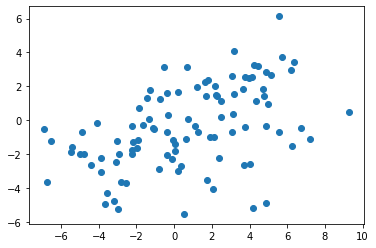

In [ ]:
# size of the latent space
latent_dim = 5
# define the discriminator model
model = define_generator(latent_dim, 100)
# generate and plot generated samples
generate_fake_samples(model, latent_dim, 100)

Running the example generates `100` random points from the latent space, uses this as input to the generator and generates `100` fake samples from our one-dimensional function domain.

As the generator has not been trained, the generated points are complete rubbish, as we expect, but we can imagine that as the model is trained, these points will slowly begin to resemble the target function and its S-shape.

We have now seen how to define and use the generator model. We will need to use the generator model in this way to create samples for the discriminator to classify.

We have not seen how the generator model is trained; that is next.

## Training the Generator Model
The weights in the **generator** model are updated based on the performance of the **discriminator** model.

When the discriminator is good at detecting fake samples, the generator is updated **more**, and when the discriminator model is relatively poor or confused when detecting fake samples, the generator model is updated **less**.

This defines the *zero-sum or adversarial* relationship between these two models.

There may be many ways to implement this using the Keras API, but perhaps the simplest approach is to create a new model that subsumes or encapsulates the generator and discriminator models.

Specifically, a new GAN model can be defined that *stacks* the generator and discriminator such that:
- the generator receives as input random points in the latent space,
- generates samples that are fed into the discriminator model directly,
- the discriminator classifies the generated samples,
- and the output of this larger model can be used to update the model weights of the generator.

To be clear, we are not talking about a new third model, just a logical third model that uses the already-defined layers and weights from the standalone generator and discriminator models.

**Only** the discriminator is concerned with distinguishing between real and fake examples; therefore, the discriminator model can be trained in a standalone manner on examples of each.

The generator model is only concerned with the discriminator’s performance on fake examples. Therefore, we will mark all of the layers in the discriminator as not trainable when it is part of the GAN model so that they can not be updated and overtrained on fake examples.

When training the generator via this subsumed GAN model, there is one more important change. We want the discriminator to think that the samples output by the generator are real, not fake. Therefore, when the generator is trained as part of the GAN model, we will mark the generated samples as real (class 1).

We can imagine that the discriminator will then classify the generated samples as not real (class `0`) or a low probability of being real (`0.3` or `0.5`). The backpropagation process used to update the model weights will see this as a large error and will update the model weights (i.e. only the weights in the generator) to correct for this error, in turn making the generator better at generating plausible fake samples.

Let’s make this concrete.

- **Inputs**: Point in latent space, e.g. a five-element vector of Gaussian random numbers.
- **Outputs**: Binary classification, likelihood the sample is real (or fake).

The `define_gan()` function below takes as arguments the already-defined generator and discriminator models and creates the new logical third model subsuming these two models. The weights in the discriminator are marked as not trainable, which only affects the weights as seen by the GAN model and not the standalone discriminator model.

The GAN model then uses the same binary cross entropy loss function as the discriminator and the efficient Adam version of stochastic gradient descent.

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model

Now we can put the GAN model together.

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 2)                 122       
                                                                 
 sequential_4 (Sequential)   (None, 1)                 101       
                                                                 
Total params: 223
Trainable params: 122
Non-trainable params: 101
_________________________________________________________________


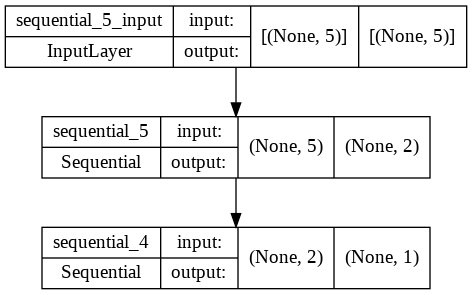

In [ ]:
# create the discriminator
discriminator = define_discriminator()

# create the generator
generator = define_generator(latent_dim)

# stacking the generator with the discriminator
gan_model = define_gan(generator, discriminator)
# summarize gan model
gan_model.summary()
# plot gan model
plot_model(gan_model, show_shapes=True, show_layer_names=True)

Training the composite model involves generating a batch-worth of points in the latent space via the `generate_latent_points()` function in the previous section, and class=1 labels and calling the `train_on_batch()` function.

The `train_gan()` function below demonstrates this, although it is pretty uninteresting as only the generator will be updated each epoch, leaving the discriminator with default model weights.

Instead, what is required is that we first update the discriminator model with real and fake samples, then update the generator via the composite model.

This requires combining elements from the `train_discriminator()` function defined in the discriminator section and the `train_gan()` function defined above. It also requires that the `generate_fake_samples()` function use the generator model to generate fake samples instead of generating random numbers.



We need a new function to generate, instead of visualize the fake samples.

In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = np.zeros((n, 1))
	return X, y


In [ ]:
# train the composite model
def train_gan(gan_model, latent_dim, n_epochs=10000, n_batch=128):
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = np.ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)

We almost have everything we need to develop a GAN for our one-dimensional function.

One remaining aspect is the evaluation of the model.

## Evaluating the Performance of the GAN
Generally, there are no objective ways to evaluate the performance of a GAN model.

In this specific case, we can devise an objective measure for the generated samples as we know the true underlying input domain and target function and can calculate an objective error measure.

Nevertheless, we will not calculate this objective error score in this tutorial. Instead, we will use the subjective approach used in most GAN applications. Specifically, we will use the generator to generate new samples and inspect them relative to real samples from the domain.

Having both samples plotted on the same graph allows them to be directly compared to see if the same input and output domain are covered and whether the expected shape of the target function has been appropriately captured, at least subjectively.

The summarize_performance() function below can be called any time during training to create a scatter plot of real and generated points to get an idea of the current capability of the generator model.

Specifically, we are interested to know how well the discriminator model can correctly identify real and fake samples. A good generator model should make the discriminator model confused, resulting in a classification accuracy closer to 50% on real and fake examples.

In [ ]:
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
	# prepare real samples
	x_real, y_real = generate_real_samples(n)
	# evaluate discriminator on real examples
	_, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
	# evaluate discriminator on fake examples
	_, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print(epoch, acc_real, acc_fake)
	# scatter plot real and fake data points
	plt.scatter(x_real[:, 0], x_real[:, 1], color='green')
	plt.scatter(x_fake[:, 0], x_fake[:, 1], color='red')
	plt.show()

The complete train function for updating the discriminator model and the generator (via the composite model) is listed below.

For example, if we choose to train the models for `10,000` iterations, it may be interesting to check-in on the performance of the model every `2,000` iterations.

We can achieve this by parameterizing the frequency of the check-in via n_eval argument, and calling the `summarize_performance()` function from the `train()` function after the appropriate number of iterations.

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=2000):
	# determine half the size of one batch, for updating the discriminator
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare real samples
		x_real, y_real = generate_real_samples(half_batch)
		# prepare fake examples
		x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator
		d_model.train_on_batch(x_real, y_real)
		d_model.train_on_batch(x_fake, y_fake)
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = np.ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)
		# evaluate the model every n_eval epochs
		if (i+1) % n_eval == 0:
			summarize_performance(i, g_model, d_model, latent_dim)

Running the example reports model performance every 5,000 training iterations (batches) and creates a plot.

Your specific results may vary given the stochastic nature of the training algorithm, and the generative model itself.

We can see that the training process is relatively unstable. The first column reports the iteration number, the second the classification accuracy of the discriminator for real examples, and the third column the classification accuracy of the discriminator for generated (fake) examples.

In this case, we can see that the discriminator remains relatively confused about real examples, and performance on identifying fake examples varies.

4999 0.9399999976158142 0.009999999776482582


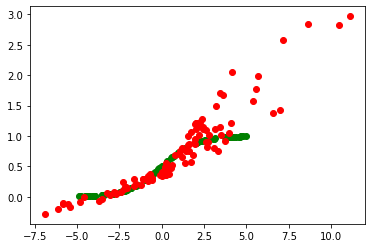

9999 0.8399999737739563 0.1599999964237213


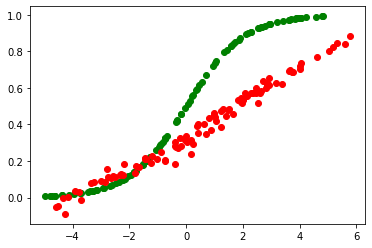

14999 0.10999999940395355 0.800000011920929


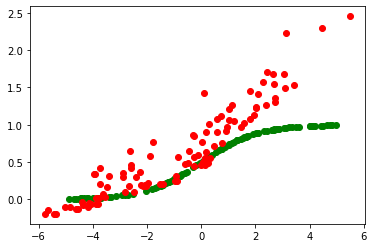

19999 0.5199999809265137 0.49000000953674316


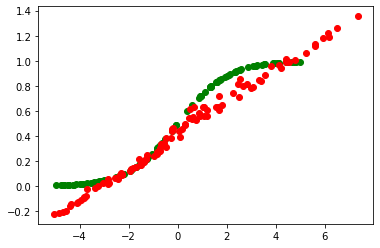

24999 0.18000000715255737 0.6800000071525574


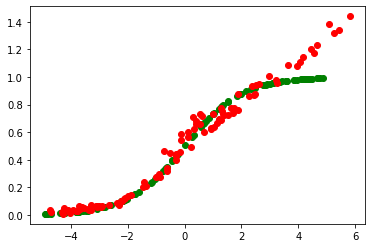

29999 0.07999999821186066 0.8799999952316284


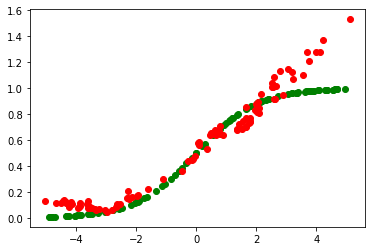

In [ ]:
# size of the latent space
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim, 30000, 128, 5000)